In [1]:
#Make imports
import numpy as np
import re
import pickle
import os
import seaborn as sns
import string

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#TPU settings
#!pip install tensorflow==2.6
#!pip install keras==2.6
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.6.0
Running on TPU  ['10.82.121.42:8470']
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.82.121.42:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.82.121.42:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [4]:
def preprocess(text):
  text = ''.join(ch for ch in text if ch not in string.punctuation)
  text = text.lower()
  text = re.sub(r'\d','',text)
  text = re.sub(r'\s+',' ',text)
  text = text.strip()
  return text

In [5]:
#Extract dataset and preprocess
dataset_root = "/content/drive/MyDrive/TDL_LANGUAGE_TRANSLATION/"

if os.path.exists(dataset_root + "preprocessed_data/preprocessed_data.pickle"):
  with open(dataset_root + "preprocessed_data/preprocessed_data.pickle", 'rb') as f:
    english_sentences, hindi_sentences = pickle.load(f)
else:
  if not os.path.exists(dataset_root + "datasets/IITB.en-hi.en"):
    os.system("tar -xzf " + dataset_root + "parallel.tgz -C " + dataset_root)

  with open(dataset_root + "datasets/IITB.en-hi.en",'r') as f:
    english_sentences = f.read().split('\n')

  with open(dataset_root + "datasets/IITB.en-hi.hi",'r') as f:
    hindi_sentences = f.read().split('\n')

  english_sentences = [preprocess(en) for en in english_sentences]
  hindi_sentences = ['<START> ' + re.sub('[a-zA-Z]','',preprocess(hi)) + ' <END>' for hi in hindi_sentences]

  #Remove duplicate sentences
  english_unique = set()
  english_sentences_temp = []
  hindi_sentences_temp = []
  l = len(english_sentences)
  for i in range(l):
    if english_sentences[i] not in english_unique:
      english_unique.add(english_sentences[i])
      english_sentences_temp.append(english_sentences[i])
      hindi_sentences_temp.append(hindi_sentences[i])

  english_sentences = english_sentences_temp
  hindi_sentences = hindi_sentences_temp
  
  with open(dataset_root + "preprocessed_data/preprocessed_data.pickle",'wb') as f:
    pickle.dump((english_sentences, hindi_sentences), f)

In [6]:
print(len(english_sentences), len(hindi_sentences))
print()
english_sentences[:3], hindi_sentences[:3]

1044136 1044136



(['give your application an accessibility workout',
  'accerciser accessibility explorer',
  'the default plugin layout for the bottom panel'],
 ['<START> अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें <END>',
  '<START> एक्सेर्साइसर पहुंचनीयता अन्वेषक <END>',
  '<START> निचले पटल के लिए डिफोल्ट प्लगइन खाका <END>'])

In [7]:
#Some parameters
vocab_size = 10000
total_sentences = 25000
maxlen = 10
epochs = 70
validation_split = 0.05

In [8]:
en_data = []
hi_data = []

cnt = 0

for (en,hi) in zip(english_sentences, hindi_sentences):
  l = min(len(en.split()), len(hi.split()))
  if l <= maxlen:
    en_data.append(en)
    hi_data.append(hi)
    cnt += 1
  if cnt == total_sentences:
    break

In [9]:
#Tokenize the texts and convert to sequences
en_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<OOV>', lower=False)
en_tokenizer.fit_on_texts(en_data)
en_sequences = en_tokenizer.texts_to_sequences(en_data)

hi_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<OOV>', lower=False)
hi_tokenizer.fit_on_texts(hi_data)
hi_sequences = hi_tokenizer.texts_to_sequences(hi_data)

english_vocab_size = len(en_tokenizer.word_index) + 1
hindi_vocab_size = len(hi_tokenizer.word_index) + 1
print("English Vocab Size: ", english_vocab_size)
print("Hindi Vocab Size: ", hindi_vocab_size)

English Vocab Size:  8020
Hindi Vocab Size:  9395


In [10]:
#Prepare encoder data
encoder_inputs = tf.keras.preprocessing.sequence.pad_sequences(en_sequences, maxlen=maxlen, padding='post')

In [11]:
#Prepare decoder data
decoder_inputs = []
decoder_outputs = []

for hi in hi_sequences:
  decoder_inputs.append(hi[:-1])
  decoder_outputs.append(hi[1:])

decoder_inputs = tf.keras.preprocessing.sequence.pad_sequences(decoder_inputs, maxlen=maxlen, padding='post')
decoder_outputs = tf.keras.preprocessing.sequence.pad_sequences(decoder_outputs, maxlen=maxlen, padding='post')

In [12]:
# Training and Testing split
# 95%, 5%
split = int(0.95 * total_sentences)

X_train = [encoder_inputs[:split], decoder_inputs[:split]]
y_train = decoder_outputs[:split]

# Test data to evaluate our NMT model using BLEU score
X_test = en_data[:split]
y_test = hi_data[:split]

print(X_train[0].shape, X_train[1].shape, y_train.shape)

(23750, 10) (23750, 10) (23750, 10)


In [1]:
X_test[0]

NameError: ignored

In [13]:
#Define LSTM model
d_model = 256

#Encoder
inputs = tf.keras.layers.Input(shape=(None,))
x = tf.keras.layers.Embedding(english_vocab_size, d_model, mask_zero=True)(inputs)
_,state_h,state_c = tf.keras.layers.LSTM(d_model,activation='relu',return_state=True)(x)

#Decoder
targets = tf.keras.layers.Input(shape=(None,))
embedding_layer = tf.keras.layers.Embedding(hindi_vocab_size, d_model, mask_zero=True)
x = embedding_layer(targets)
decoder_lstm = tf.keras.layers.LSTM(d_model,activation='relu',return_sequences=True, return_state=True)
x,_,_ = decoder_lstm(x, initial_state=[state_h, state_c])
dense1 = tf.keras.layers.Dense(hindi_vocab_size, activation='softmax')
x = dense1(x)

model = tf.keras.models.Model(inputs=[inputs, targets],outputs=x)
model.summary()

loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='rmsprop', loss=loss, metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    2053120     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    2405120     input_2[0][0]                    
______________________________________________________________________________________________

In [14]:
#Save model after each epoch
save_model_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/TDL_LANGUAGE_TRANSLATION/models/en-hi.h5',
    monitor='val_accuracy',
    mode='max'
)

In [ ]:
model.fit(X_train, y_train, epochs=epochs, validation_split=validation_split, callbacks=[save_model_callback, tf.keras.callbacks.TerminateOnNaN()])

Epoch 1/70
706/706 [==============================] - 43s 56ms/step - loss: 2.7458 - accuracy: 0.2309 - val_loss: 2.3165 - val_accuracy: 0.2792
Epoch 2/70
706/706 [==============================] - 39s 55ms/step - loss: 2.4136 - accuracy: 0.2833 - val_loss: 2.1945 - val_accuracy: 0.3167
Epoch 3/70
706/706 [==============================] - 39s 55ms/step - loss: 2.2583 - accuracy: 0.3132 - val_loss: 2.1686 - val_accuracy: 0.3249
Epoch 4/70
706/706 [==============================] - 39s 55ms/step - loss: 2.1403 - accuracy: 0.3410 - val_loss: 2.1597 - val_accuracy: 0.3363
Epoch 5/70
706/706 [==============================] - 39s 55ms/step - loss: 2.0399 - accuracy: 0.3662 - val_loss: 2.1352 - val_accuracy: 0.3476
Epoch 6/70
706/706 [==============================] - 39s 55ms/step - loss: 1.9484 - accuracy: 0.3911 - val_loss: 2.1280 - val_accuracy: 0.3552
Epoch 7/70
706/706 [==============================] - 39s 55ms/step - loss: 1.8661 - accuracy: 0.4138 - val_loss: 2.1298 - val_accuracy:

In [15]:
#Retrieve previously saved stuff
saved_model = tf.keras.models.load_model('/content/drive/MyDrive/TDL_LANGUAGE_TRANSLATION/models/en-hi.h5')

saved_model.summary()

inputs = saved_model.get_layer('input_1').output
_,state_h,state_c = saved_model.get_layer('lstm').output
targets = saved_model.get_layer('input_2').output
embedding_layer = saved_model.get_layer('embedding_1')
decoder_lstm = saved_model.get_layer('lstm_1')
dense1 = saved_model.get_layer('dense')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    2053120     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    2405120     input_2[0][0]                    
______________________________________________________________________________________________

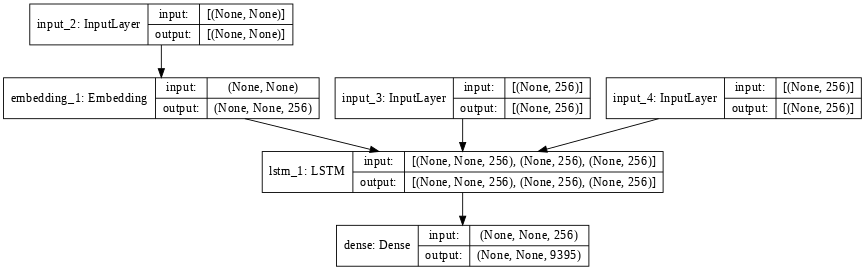

In [16]:
#Inference Model

#Encoder
encoder = tf.keras.models.Model(inputs, [state_h, state_c])

#Decoder
decoder_input_h = tf.keras.layers.Input(shape=d_model)
decoder_input_c = tf.keras.layers.Input(shape=d_model)
x = embedding_layer(targets)
x, decoder_output_h, decoder_output_c = decoder_lstm(x , initial_state=[decoder_input_h, decoder_input_c])
x = dense1(x)
decoder = tf.keras.models.Model([targets,decoder_input_h, decoder_input_c], 
                                [x,decoder_output_h, decoder_output_c])
#tf.keras.utils.plot_model(encoder,show_shapes=True,dpi=64)
tf.keras.utils.plot_model(decoder,show_shapes=True,dpi=64)

In [17]:
def predict_sentence(en_input):
  input_seq = en_tokenizer.texts_to_sequences([en_input])
  next_h, next_c = encoder.predict(input_seq)
  curr_token = np.zeros(1)
  curr_token[0] = hi_tokenizer.word_index['<START>']
  pred_sentence = ''

  for i in range(maxlen):
    output, next_h, next_c = decoder.predict([curr_token] + [next_h, next_c])

    next_token = np.argmax(output[0, 0, :])
    next_word = hi_tokenizer.index_word[next_token]
    if next_word == '<END>':
      break
    else:
      pred_sentence += ' ' + next_word
      curr_token[0] = next_token

  return pred_sentence

In [18]:
!pip install transformers -U -q

In [19]:
! pip install sentencepiece

In [20]:
!pip freeze | grep transformers

transformers==4.18.0


In [21]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast

In [22]:
model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-one-to-many-mmt")

In [23]:
tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-one-to-many-mmt", src_lang="en_XX")

In [24]:
#Testing and Analysis
import nltk

candidates = []
references = []

ctr = 20 
i = 0
# print(X_test[i].split())
while ctr>0:
  l = len(X_test[i].split())
  if l<=maxlen:   #Choose only sentences of length in range [5,15]
    pred_sentence = predict_sentence(X_test[i])
    candidates.append(pred_sentence.split())

    print("Input: ", X_test[i])
    print("Prediction: ", pred_sentence)
    model_inputs = tokenizer(X_test[i], return_tensors="pt")
    generated_tokens = model.generate(
    **model_inputs,
    forced_bos_token_id=tokenizer.lang_code_to_id["hi_IN"]
  )
    translation = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    #translated_sentence = translate(X_test[i],"hi")
    # google_translated_sentence = translate_client.translate(X_test[i], target_language='hi')['translatedText']
    
    print("Translated Reference: ", translation[0])
    print("Dataset Reference: ", ' '.join(y_test[i].split()[1:-1]))
    print()
    references.append([y_test[i].split()[1:-1],translation[0].split()])

    ctr -= 1
  i += 1


Input:  give your application an accessibility workout
Prediction:   अपने अनुप्रयोग को तरह रहे
Translated Reference:  अपने अनुप्रयोग को एक अभिगमता व्यायाम दें
Dataset Reference:  अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें

Input:  accerciser accessibility explorer
Prediction:   एक्सेर्साइसर पहुंचनीयता अन्वेषक
Translated Reference:  अभिवर्धक अभिगम्यता अन्वेषक
Dataset Reference:  एक्सेर्साइसर पहुंचनीयता अन्वेषक

Input:  the default plugin layout for the bottom panel
Prediction:   संदेश का उपयोग हेतु तयशुदा चौड़ाई
Translated Reference:  निचले पटल के लिए डिफ़ॉल्ट प्लगइन सजावट
Dataset Reference:  निचले पटल के लिए डिफोल्ट प्लगइन खाका

Input:  the default plugin layout for the top panel
Prediction:   कार्य खाका लाइनों को फैक्ट्री
Translated Reference:  शीर्ष पटल के लिए डिफ़ॉल्ट प्लगइन सजावट
Dataset Reference:  ऊपरी पटल के लिए डिफोल्ट प्लगइन खाका

Input:  a list of plugins that are disabled by default
Prediction:   चयनित वस्तुओं का नाम सक्रिय है
Translated Reference:  डिफ़ॉल्ट रूप से अक्ष